<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q d2l

     |████████████████████████████████| 82 kB 541 kB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 11.2 MB 54.4 MB/s 
     |████████████████████████████████| 9.9 MB 44.2 MB/s 
     |████████████████████████████████| 900 kB 49.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
import torch
from d2l import torch as d2l

In [8]:
import shutil

import requests

url = r'https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg'
response = requests.get(url, stream=True)
with open('catdog.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response


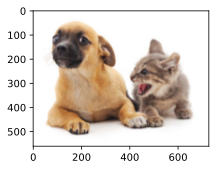

In [9]:
d2l.set_figsize()
img = d2l.plt.imread('/content/catdog.jpg') 
d2l.plt.imshow(img);

# Bounding Boxes

In object detection, we usually use a bounding box to describe the spatial location of an object. The bounding box is rectangular, which is determined by the x and y coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner. Another commonly used bounding box representation is the (x, y)-axis coordinates of the bounding box center, and the width and height of the box.
Here we define functions to convert between these two representations: box_corner_to_center converts from the two-corner representation to the center-width-height presentation, and box_center_to_corner vice versa. The input argument boxes should be a two-dimensional tensor of shape (n, 4), where n is the number of bounding boxes.

In [10]:
def box_corner_to_center(boxes):
  """Convert from (upper-left, lower-right) to (center, width, height).""" 
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=-1)
  return boxes # n X 4

def box_center_to_corner(boxes):
  """Convert from (center, width, height) to (upper-left, lower-right).""" 
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes # n X 4

The origin of the coordinates in the image is the upper-left corner of the image, and to the right and down are the positive directions of the x and y axes, respectively.

In [11]:
# x1,y1,x2,y2 format
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [12]:
def bbox_to_rect(bbox, color):
  """Convert bounding box to matplotlib format."""
  # Convert the bounding box (upper-left x, upper-left y, lower-right x, lower-right y) 
  #format to the matplotlib format: ((upper-left x, upper-left y), width, height)
  return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
                           fill=False, edgecolor=color, linewidth=2)

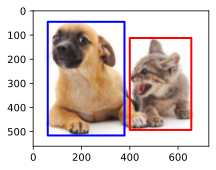

In [13]:
fig = d2l.plt.imshow(img) 
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue')) 
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# Anchor Boxes

Suppose that the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel of the image. Let the scale be s ∈ (0, 1] and the aspect ratio (ratio of width to height) is r > 0. **Then the width and height of the anchor box are ws√r and hs/√r, respectively.** 

Note that when the center position is given, an anchor box with known width and height is determined.

To generate multiple anchor boxes with different shapes, let us set a series of scales s1, . . . , sn and a series of aspect ratios r1, . . . , rm. 

When using all the combinations of these scales and aspect ratios with each pixel as the center, the input image will have a total of **whnm** anchor boxes. Although these anchor boxes may cover all the ground-truth bounding boxes, the computational complexity is easily too high. In practice, we can only consider those combinations containing s1 or r1:
(s1, r1), (s1, r2), . . . , (s1, rm), (s2, r1), (s3, r1), . . . , (sn, r1).


That is to say, the number of anchor boxes centered on the same pixel is n + m − 1. For the entire input image, we will generate **wh(n + m − 1)** anchor boxes.

In [15]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])

grid_x, grid_y = torch.meshgrid(x, y)

print(grid_x)
grid_y


tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])


tensor([[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])

In [16]:
def multibox_prior(data, sizes, ratios):
  """Generate anchor boxes with different shapes centered on each pixel.""" 
  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios) 
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)
  # Offsets are required to move the anchor to the center of a pixel. Since 
  # a pixel has height=1 and width=1, we choose to offset our centers by 0.5 
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # Scaled steps in y axis
  steps_w = 1.0 / in_width # Scaled steps in x axis

  # Generate all center points for the anchor boxes
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h 
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w 
  shift_y, shift_x = torch.meshgrid(center_h, center_w)
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

  # Generate `boxes_per_pixel` number of heights and widths that are later 
  # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax) 
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),sizes[0] * torch.sqrt(ratio_tensor[1:])))* in_height / in_width  # Handle rectangular inputs 
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:]))) 
  # Divide by 2 to get half height and half width
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat( in_height * in_width, 1) / 2

  # Each center point will have `boxes_per_pixel` number of anchor boxes, so 
  # generate a grid of all anchor box centers with `boxes_per_pixel` repeats 
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel, dim=0) 
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0) #returns (1,wh(n+m-1),4)

In [17]:
h, w = img.shape[:2]
print(h, w)

X = torch.rand(size=(1, 3, h, w)) # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]) 
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [19]:
561*728*(3+3-1) # wh(n+m-1)

2042040

After changing the shape of the anchor box variable Y to (image height, image width, number of anchor boxes centered on the same pixel, 4), we can obtain all the anchor boxes centered on a specified pixel position. In the following, we access the first anchor box centered on (250, 250). It has four elements: the (x, y)-axis coordinates at the upper-left corner and the (x, y)-axis coordinates at the lower-right corner of the anchor box. The coordinate values of both axes are divided by the width and height of the image, respectively; thus, the range is between 0 and 1.

In [21]:
n=m=3
boxes = Y.reshape(h, w, n+m-1, 4) 
boxes.shape

torch.Size([561, 728, 5, 4])

In [22]:
#For pixel 250,250 first bounding box
boxes[250, 250, 0, :]

tensor([0.0551, 0.0715, 0.6331, 0.8215])

In [23]:
def show_bboxes(axes, bboxes, labels=None, colors=None): 
  """Show bounding boxes."""
  def make_list(obj, default_values=None): 
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    
    return obj
  labels = make_list(labels)
  colors = make_list(colors, ['b', 'g', 'r', 'm', 'c']) 
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = d2l.bbox_to_rect(bbox.detach().numpy(), color) 
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w' 
      axes.text(rect.xy[0], rect.xy[1], labels[i],va='center', ha='center', fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

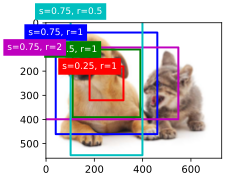

In [26]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h)) #Scale x1,y1 and x2,y2
fig = d2l.plt.imshow(img)

show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5'])

# Intersection Over Union